In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2 
from tqdm import tqdm
import random

import warnings
warnings.filterwarnings("ignore")


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers

import numpy as np
import collections
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import LearningRateSchedule


E0000 00:00:1751953557.565794      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751953557.625884      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 2


# Load the Data

https://www.kaggle.com/datasets/orvile/gastric-cancer-histopathology-tissue-image-dataset

This dataset comprises 31,096 non-overlapping images, each with a size of 224x224 pixels. These images were extracted from H&E-stained pathological slides of human gastric cancer obtained from Harbin Medical University Cancer Hospital. 

The dataset focuses on the tumor microenvironment (TME) and includes images categorized into eight distinct tissue types:

    ADI: Adipose (fat tissue)
    DEB: Debris (cellular waste) 
    LYM: Lymphocytes (immune cells)
    MUC: Mucus (protective secretion)
    MUS: Smooth Muscle (muscle tissue)
    NOR : Normal Colon Mucosa
    STR: Cancer-associated Stroma (connective tissue around the tumor)
    TUM: Tumor (cancerous tissue) 
    
    

In [4]:
path = "/kaggle/input/gastric-cancer-histopathology-tissue-image-dataset/HMU-GC-HE-30K/all_image"

In [5]:
tissue_types = os.listdir(path)
tissue_types.sort()
tissue_types

['ADI', 'DEB', 'LYM', 'MUC', 'MUS', 'NOR', 'STR', 'TUM']

Lets plot some images for each tissue types

ADI


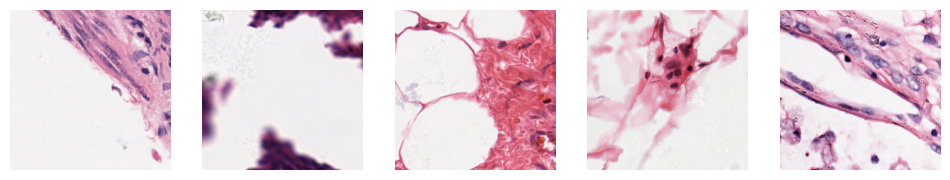

DEB


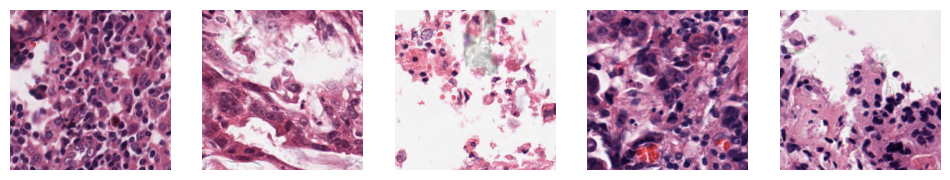

LYM


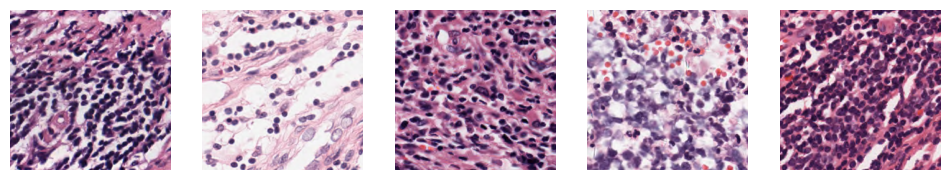

MUC


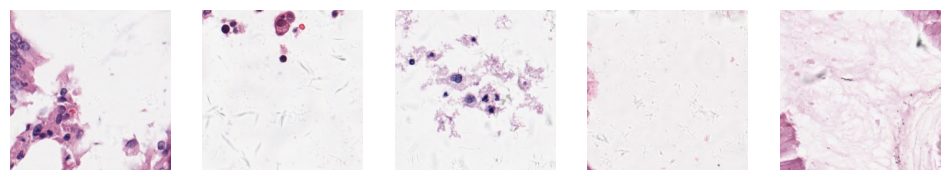

MUS


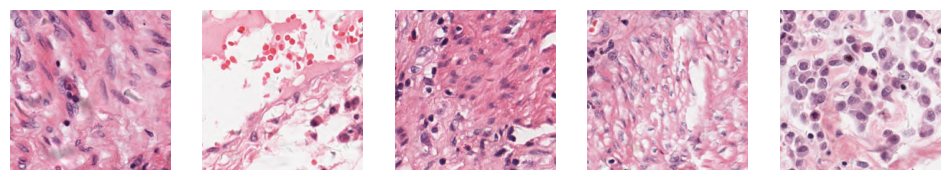

NOR


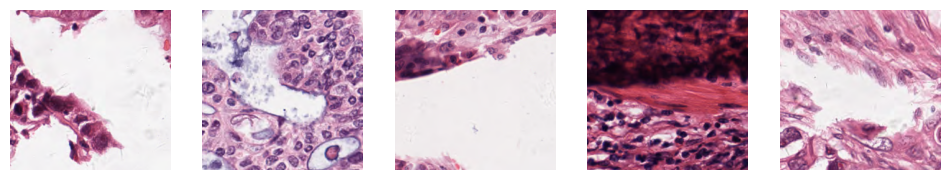

STR


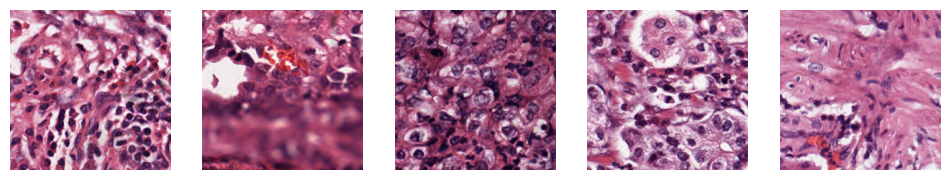

TUM


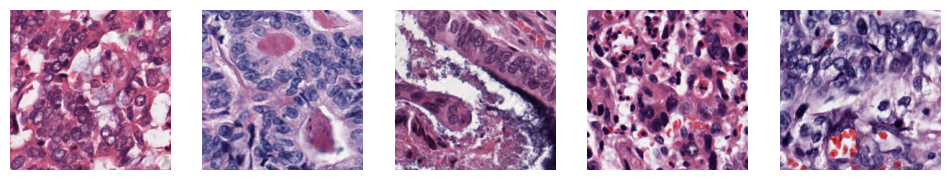

In [37]:
images_per_label = 5
for tissue in tissue_types:
    folder_path = os.path.join(path, tissue)
    folder_files = os.listdir(folder_path)
    random_ind=np.random.randint(0, len(folder_files),images_per_label)
    fig, ax = plt.subplots(1, images_per_label, figsize=(12, 10))
    print(tissue)
    for i, ind in enumerate(random_ind):     
        img = plt.imread(folder_path+'/'+folder_files[ind])
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()



In [7]:
for tissue in tissue_types:
    folder_path = os.path.join(path, tissue)
    if os.path.isdir(folder_path):
        num_images = len([f for f in os.listdir(folder_path)])
        print(f"{tissue}: {num_images} images")

ADI: 3887 images
DEB: 3887 images
LYM: 3887 images
MUC: 3887 images
MUS: 3887 images
NOR: 3887 images
STR: 3887 images
TUM: 3887 images


# Create a train and validation dataset

In [8]:
# 85-15 split 

train_ds,val_ds = tf.keras.utils.image_dataset_from_directory(
  path,
  labels='inferred',
  validation_split=0.15,
  subset='both',
  seed=85,
  batch_size=16,
  image_size=(224, 224),
  shuffle=True
  )


Found 31096 files belonging to 8 classes.
Using 26432 files for training.
Using 4664 files for validation.


I0000 00:00:1751953597.337748      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751953597.338488      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


To make sure we have the datasets as intended we can visualize the class names.

In [9]:
train_ds.class_names

['ADI', 'DEB', 'LYM', 'MUC', 'MUS', 'NOR', 'STR', 'TUM']

 We can also fetch one batch of images and labels in the train dataset and look at the shape.


In [10]:
image, label = next(iter(train_ds))
print(image.shape)
print(label.shape)

(16, 224, 224, 3)
(16,)


Look at the class distribution to see if there is any imbalance.

In [11]:
train_labels = []
for _, labels in train_ds:
    train_labels.extend(labels.numpy())

train_label_counts = collections.Counter(train_labels)
print("Train label distribution:")
print(dict(sorted(train_label_counts.items())))

val_labels = []
for _, labels in val_ds:
    val_labels.extend(labels.numpy())

val_label_counts = collections.Counter(val_labels)
print("\nValidation label distribution:")
print(dict(sorted(val_label_counts.items())))

Train label distribution:
{0: 3330, 1: 3298, 2: 3316, 3: 3316, 4: 3277, 5: 3306, 6: 3312, 7: 3277}

Validation label distribution:
{0: 557, 1: 589, 2: 571, 3: 571, 4: 610, 5: 581, 6: 575, 7: 610}


The sample distributions look reasonably balanced across train, test, and validation sets which is good.


# Train the Model

In [11]:
# save the number of class labels
num_labels=len(train_ds.class_names)

In [12]:
# use buffered prefetching for performance
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

We use the pretrained mode `EfficientNetB1` for training the dataset. 

In [22]:
data_augmentation = tf.keras.Sequential([layers.RandomFlip("horizontal"),layers.RandomRotation(0.1),layers.RandomZoom(0.1)])

In [19]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0,Xception,EfficientNetB1,EfficientNetB3

input_tensor = tf.keras.Input(shape=(224, 224, 3))

#x = data_augmentation(input_tensor)
x = layers.Rescaling(1./255)(input_tensor)

base_model = EfficientNetB1(include_top=False, weights='imagenet', input_tensor=x)
x = base_model.output

x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x) 
#x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
output_tensor = layers.Dense(8, activation='softmax')(x)

model = models.Model(inputs=input_tensor, outputs=output_tensor)


Set up an early stopping condition and save the best model with minimum validation loss as the metric:

In [20]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.005, # minimium amount of change to count as an improvement
    patience=4, # how many epochs to wait before stopping
    restore_best_weights=True
)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    "/kaggle/working/efficientnetb1_baseline.h5",
    save_best_only=True,
    monitor="val_loss",
    mode="min"
)

Define the opimizer, compile the model and run:

In [21]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
history = model.fit(train_ds, epochs=16, validation_data=val_ds, callbacks=[early_stopping, checkpoint_callback])

Epoch 1/16
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 309s 119ms/step - accuracy: 0.3307 - loss: 1.7738 - val_accuracy: 0.5776 - val_loss: 1.1882
Epoch 2/16
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 182s 110ms/step - accuracy: 0.5577 - loss: 1.2063 - val_accuracy: 0.6295 - val_loss: 1.0108
Epoch 3/16
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 182s 110ms/step - accuracy: 0.6054 - loss: 1.0633 - val_accuracy: 0.6619 - val_loss: 0.9155
Epoch 4/16
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 180s 109ms/step - accuracy: 0.6403 - loss: 0.9716 - val_accuracy: 0.6402 - val_loss: 0.9825
Epoch 5/16
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 182s 110ms/step - accuracy: 0.6570 - loss: 0.9209 - val_accuracy: 0.6795 - val_loss: 0.8520
Epoch 6/16
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 182s 110ms/step - accuracy: 0.6765 - loss: 0.8683 - val_accuracy: 0.6925 - val_loss: 0.8288
Epoch 7/16
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 182s 110ms/step - accuracy: 0.6910 - loss: 0.8323 - val_accuracy: 0.6578 - val_loss: 0.9242
Epoch 8/16
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 182s 110ms/step - ac

Plot the evolution of accuracy and loss for the train and validation dataset:

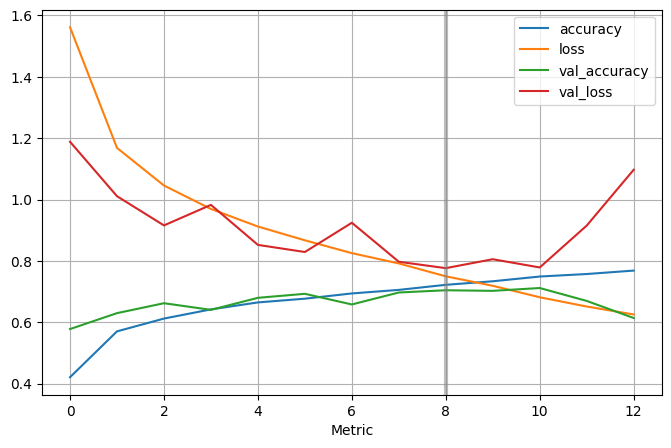

In [26]:
pd.DataFrame(history.history).plot(figsize=(8, 5)) 
plt.axvline(8,lw=3,color='grey',alpha=0.5)
plt.grid(True)
plt.xlabel("Epoch-1")
plt.xlabel("Metric")
plt.show()

Based on the diagram:
* The training loss steadily decreases, and the training accuracy increases throughout training.
* Validation loss decreases but with fluctuations and reaches its low at epoch 8 before rising again.
* Validation accuracy is more or less close to the training accuracy until epoch 8, after which it starts to decline.

This indicates that the model begins to overfit after epoch 8. We treat this as our baseline model. The next step is fine-tuning to improve performance and reach the desired accuracy.

In [30]:
best_epoch = np.argmin(history.history['val_loss'])+1
best_val_loss = np.min(history.history['val_loss'])
val_accuracy = history.history['val_accuracy'][np.argmin(history.history['val_loss'])]
print(f"Best val_loss was {best_val_loss:.4f} at epoch {best_epoch}")
print(f"Best val_acc was {val_accuracy:.4f} at epoch {best_epoch}")

Best val_loss was 0.7762 at epoch 9
Best val_acc was 0.7041 at epoch 9


Compute AUC score:

In [34]:
from sklearn.metrics import roc_auc_score

y_pred_probs = model.predict(val_ds)
y_true = np.concatenate([y for x, y in val_ds], axis=0)

# Compute AUC
auc = roc_auc_score(y_true, y_pred_probs, multi_class='ovr')
print(f"AUC: {auc:.4f}")


292/292 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step
AUC: 0.9550


Compute the confusion matrix:

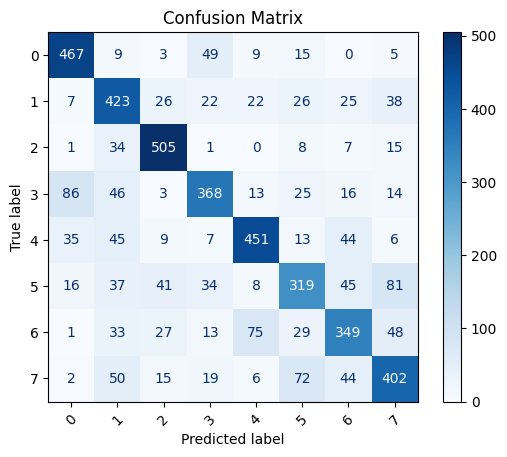

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


In [36]:
from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred, digits=4)
print(report)


              precision    recall  f1-score   support

           0     0.7593    0.8384    0.7969       557
           1     0.6248    0.7182    0.6682       589
           2     0.8029    0.8844    0.8417       571
           3     0.7173    0.6445    0.6790       571
           4     0.7723    0.7393    0.7554       610
           5     0.6292    0.5491    0.5864       581
           6     0.6585    0.6070    0.6317       575
           7     0.6601    0.6590    0.6596       610

    accuracy                         0.7041      4664
   macro avg     0.7031    0.7050    0.7024      4664
weighted avg     0.7026    0.7041    0.7017      4664



With the baseline `EfficientNetB1`, we have acheived the following metrics:

    Accuracy: 70.4% — good baseline, especially with 8 classes.

    Macro F1-score: 0.702 — well-balanced performance across classes.

    AUC: 0.95 — strong class separability.

From the confusion matrix:

    Class 0 (467), Class 2 (505), Class 4 (451) are well-predicted.
    
    Class 7 largely confused with class 5 (72).
    Class 6 largely confused with Class 4 (75).
    Class 5 largely confused with class 7 (81).
    Class 4 largely confused with 0 (35),1 (45) and 6 (44).
    Class 3 largely confused with class 0 (86)
    class 2 largely confused with class 1 (34)
    Class 1 is spread out (26+ values in several cols) 
    Class 0 largely confused with class 3 (49).
    
    
    

Class 5 and Class 7 are getting confused with each other. Looking at which tissue types these are, we can see that Class 5 is Normal colon mucosa aka healthy tissue. Class 7 is actually the tumor. Which means this confusion needs immediate attention, since this has direct clinical significance. 


We can try to fine tune our model now. 
